In [1]:
import sys
sys.path.append('/import/silo2/aloe8475/Documents/edamame')

In [2]:
import plotly.graph_objects as go


In [3]:
from scipy.io import loadmat, savemat
from scipy.stats import kurtosis, skew

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import datetime
import networkx as nx
from edamame import *
from tqdm.notebook import tqdm_notebook as tqdm
import os
import edamame.core.wires as wires
from random import choice
from IPython.core.debugger import set_trace
# import nct
import bct

import pickle 
import _pickle as cPickle
import gzip
def compressed_pickle(obj, filename,protocol=-1):
    with gzip.open(filename, 'wb') as f:
        cPickle.dump(obj, f, protocol)
def decompress_pickle(file):
    with gzip.open(file, 'rb') as f:
        loaded_object = cPickle.load(f)
        return loaded_object

In [4]:
dataLoc='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/Hierarchical Results/VSweep/'
saveFig='/import/silo2/aloe8475/Documents/CODE/Data/Figures/Functional Connectivity/'

In [5]:
name='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/Hierarchical Networks/New/HierarchicalNW_AdjMat.mat'
HNW=loadmat(name)
HNW=HNW['AdjMat']

In [6]:
cd "/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/"

/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity


In [7]:

adj=[None]*10
for i in range(10):
    name='Hierarchical Networks/New/2Mods 3Levels/hierarchical_'+str(i+1)+'_2x3_25Connections_75Nodes.pkl'
# name='hierarchical_256_Nodes.pkl'
    file = open(name, 'rb')
    adj[i] = pickle.load(file)

In [8]:
HNW=[None]*len(adj)
for i in tqdm(range(len(adj))):
    HNW[i]={'AdjMat':[],'G':[],'Accuracy':{'NLT':[None]*6,'MC':[]},'Graph Theory':{'Shortest Path':[]}}
    HNW[i]['AdjMat']=adj[i]
    G=nx.from_numpy_matrix(HNW[i]['AdjMat'])
    G2=max((G.subgraph(c) for c in nx.connected_components(G)), key=len)
    if len(G2)>277:
        HNW[i]['G']=G2    

  0%|          | 0/10 [00:00<?, ?it/s]

In [9]:
HNW[1]['G'].number_of_edges()

4788

In [10]:
# folder='/import/silo2/aloe8475/Documents/CODE/Data/Functional Connectivity/ModularNWNs/VSweep/'
# graphMod=decompress_pickle(folder+'2ModuleSameAvgDegGraphs')

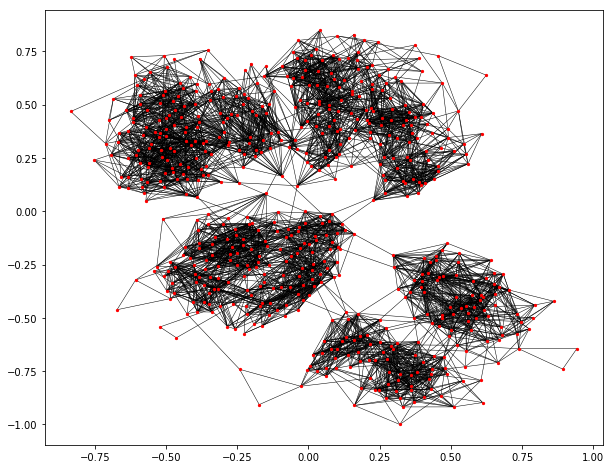

In [55]:
plt.figure(figsize=(10,8))
pos=nx.kamada_kawai_layout(HNW[0]['G'])
nx.draw_networkx(HNW[0]['G'],pos=pos,width=0.5,with_labels=False,node_size=5)

In [12]:
ci,q=bct.community_louvain(np.array(nx.adjacency_matrix(HNW[1]['G']).todense()),gamma=1.1)

In [38]:
graph=[];avgSPL=[];SPLsource_drain=[]
for i in tqdm(range(len(HNW))):
    graph.append(HNW[i]['G'])
    avgSPL.append(nx.average_shortest_path_length(graph[i]))
    elecs=getFarthestPairing(nx.adjacency_matrix(graph[i]).todense())
    SPLsource_drain.append(nx.shortest_path(graph[i],elecs[0],elecs[1]))

  0%|          | 0/10 [00:00<?, ?it/s]

In [50]:
np.mean(list(dict(graph[0].degree()).values()))

15.026666666666667

In [19]:
#save networks separately so Dask can run it more efficiently
count = 1
for i in tqdm(range(len(HNW))):#For each network
    n=connectivity__(graph=graph[i])
    compressed_pickle(n,dataLoc+'/NWN_Hierarchical Network_2x3_'+str(i+1)+'.pkl')
    count = count+1

/suphys/aloe8475/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/10 [00:00<?, ?it/s]

In [10]:
onAmp=[0.2,0.5,0.75,1,1.25,1.5,1.75,2,3,5,10]

In [11]:
def nonLinearTrans_specificNodes(network, targetType, nodesList, repeats = 1,time=10,dt=1e-3):
    """
    targetType can be DoubleFrequency and all other possible biasType.
    wireVoltage[T,N] can also be the first positional parameter.
    """
    from edamame.core.simSettings import stimulus__

    if targetType == 'DoubleFrequency':
        target = stimulus__(network.stimulus[0].biasType, network.TimeVector, f = 2*network.stimulus[0].f).signal
    else:
        target = stimulus__(targetType, dt=dt,T=time, f = network.stimulus[0].f).signal
        
    wireVoltage = network.wireVoltage    
    T, N = wireVoltage.shape
    output = dict()
    accuracy = np.zeros(repeats)
    weight = np.zeros((repeats, len(nodesList)+1))
    result = np.zeros((repeats, T))
    for i in range(repeats):
        lhs = np.hstack((np.ones((T, 1)), wireVoltage[:,nodesList]))
        weight[i,:] = np.linalg.lstsq(lhs, target, rcond = None)[0]
#         set_trace()
        result[i,:] = np.dot(lhs, weight[i,:])
        accuracy[i] = 1-getRNMSE(result[i,:], target)
        
    output['weight'] = np.mean(weight, axis = 0)
    output['result'] = np.mean(result, axis = 0)
    output['accuracy'] = np.mean(accuracy)
    output['target'] = target
    
    return output 

In [12]:
def nonlineartrans(network,j,amp=onAmp):
    
    ampName=str(amp).replace('.','p')
    Connectivity=decompress_pickle(dataLoc+'NWN_Hierarchical Network_2x3_'+str(j+1)+'.pkl')
    Graph= nx.from_numpy_matrix(Connectivity.adj_matrix)
    stimulus=[]
    dt = 1e-3
    f=0.5
    Time=10

    #Choose Electrode Pattern
    stimulus.append((stimulus__(biasType='AC',onAmp=amp,T=Time,dt=dt,f=f)))
    stimulus.append((stimulus__(biasType='Drain',T=Time,dt=dt))) #we don't want this drain to be active during training
    
    results_minMax=runSim(connectivity__(graph=Graph),stimulus=stimulus, contactMode='farthest',T = Time, dt = dt, onAmp = amp, biasType='AC',f=f,junctionMode='tunneling',findFirst=False,disable_tqdm=False)
    
#     results={'JunctionConductance':results_minMax.junctionConductance[-1],'JunctionVoltage':results_minMax.junctionVoltage[-1],'Switch':results_minMax.junctionSwitch[-1],'Source':results_minMax.sources[0:2],'Drain':results_minMax.drains[0:2],'Signal':results_minMax.stimulus,'conductance':results_minMax.conductance}
#     compressed_pickle(results,dataLoc+'_NLT_Simulation_'+'_2modules_Rewired_Network_'+str(j+1)+'_'+str(k+1)+'_'+ampName+'v.pkl')
#             compressed_pickle(results,r'/project/NASN/Alon/'+nwType+'/'+nwType+' Results/'+nwType+'_NLT_Simulation_'+'Density_Network_'+str(j+1)+'_'+ampName+'v.pkl')
    results_minMax.frequency=f
    results_minMax.dt=dt
    period=1/f
    
    nodesList = np.array([i for i in Graph.nodes]) #if we want to measure from all nodes
    
#     if elecs[0] in module1:   #if the NLT electrode is in module one, we only want to sample from those nodes
#         nodesList=module1 #only want nodes in first module
#     else:
#         nodesList=module2
        
    ResultSqu = nonLinearTrans_specificNodes(results_minMax,'Square',nodesList, repeats=50,time=Time,dt=dt) #simulation, type of signal, number of nodes to sample from, number of linear regression repetitions (take avg)
    nwSqu=ResultSqu['accuracy']
        
    return nwSqu


In [41]:
init=[]
for i in tqdm(range(len(onAmp))): #for each voltage
    for j in range(len(HNW)):#for each modularity:
        init.append(inputPacker(nonlineartrans,HNW[j],j,amp=onAmp[i]))

  0%|          | 0/11 [00:00<?, ?it/s]

In [43]:
resultNLT=para_run(nonlineartrans,init,nCPU=10,start_method='fork')

  0%|          | 0/110 [00:00<?, ?it/s]

Running Simulation : 100%|██████████| 10000/10000 [02:29<00:00, 67.05it/s]


In [44]:
resultNLT=np.array(resultNLT).reshape(11,10)

In [45]:
resultNLT

array([[0.64064577, 0.6478571 , 0.62985972, 0.56522865, 0.62520546,
        0.62883276, 0.62849187, 0.63230437, 0.63397685, 0.56522865],
       [0.65214014, 0.65685247, 0.66640472, 0.67294498, 0.66338688,
        0.66348823, 0.66420832, 0.66329848, 0.66395914, 0.6628986 ],
       [0.67016611, 0.67935067, 0.67202795, 0.67130878, 0.66909379,
        0.67909778, 0.67236955, 0.67420907, 0.67475041, 0.67564082],
       [0.67315761, 0.68213402, 0.67873373, 0.67957093, 0.67827812,
        0.68200558, 0.67954836, 0.67904682, 0.68128243, 0.67692613],
       [0.68118529, 0.70740654, 0.71783564, 0.68531807, 0.70058089,
        0.71101808, 0.70353388, 0.70891955, 0.69107421, 0.68158598],
       [0.69974065, 0.71387718, 0.72256773, 0.77483153, 0.79954473,
        0.79682999, 0.77258081, 0.76391388, 0.84313724, 0.70881311],
       [0.8211311 , 0.85883595, 0.82388981, 0.82923678, 0.79914626,
        0.83898648, 0.85512134, 0.82464932, 0.83172608, 0.72463883],
       [0.82523189, 0.8479151 , 0.8456085

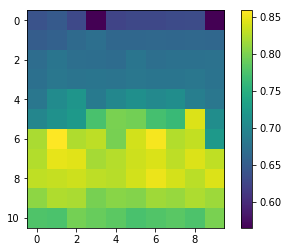

In [46]:
plt.imshow(resultNLT)
plt.colorbar()

In [13]:
def MC_k_new(network, k = 1, node_list=[], transient = 100):
#     node_list=n_outs#len(node_list)
    signal = network.stimulus[0].signal[transient:]
    wire_voltage = network.wireVoltage[transient:]
    T, N = wire_voltage.shape
#     node_list = np.random.choice(range(0, N), n_outs, replace = False)
    
    lhs = wire_voltage[k:,node_list]
    rhs = signal[:-k]
    try:
        weight = np.linalg.lstsq(lhs, rhs, rcond = None)[0]
        result = np.matmul(lhs, weight)
        mc = (np.cov(rhs, result)[0,1])**2/(np.var(signal[k:])*np.var(result))
        return mc
    except:
        return 0

In [14]:
def get_MC_Voltsweep(j,amp = 2, dt = 0.01, dur = 1, n_outs = 100, init_state = None, return_sim = False):
    ampName=str(amp).replace('.','p')
    Connectivity=decompress_pickle(dataLoc+'NWN_Hierarchical Network_2x3_'+str(j+1)+'.pkl')
    Graph= nx.from_numpy_matrix(Connectivity.adj_matrix)
    stimulus=[]

    stimulus=[]
    stimulus.append(stimulus__(biasType='Custom',T=10,dt=dt,customSignal=signal_expand(np.random.random(1000)*2*amp-amp, dur)))
    stimulus.append(stimulus__(biasType='Drain',T=10,dt=dt)) #we don't want this drain to be active during training
    simRAND = runSim(connectivity__(graph=Graph), T = 10, dt = dt,
                stimulus=stimulus,
                biasType = 'Custom', customSignal = signal_expand(np.random.random(1000)*2*amp-amp, dur), 
                junctionMode = 'tunneling', 
#                 electrodes=elecs[-2:],
                contactMode = 'farthest',
                findFirst=False, disable_tqdm=True)    
    
    nodesList = np.array([i for i in Graph.nodes]) #if we want to measure from all nodes
    
#     results={'JunctionConductance':simRAND.junctionConductance[-1],'JunctionVoltage':simRAND.junctionVoltage[-1],'Switch':simRAND.junctionSwitch[-1],'Source':simRAND.sources[0:2],'Drain':simRAND.drains[0:2],'Signal':simRAND.stimulus,'conductance':simRAND.conductance}
#     compressed_pickle(results,dataLoc+'_MC_Simulation_'+'_2modules_Rewired_Network_'+str(j+1)+'_'+str(k+1)+'_'+ampName+'v.pkl')

    mcRAND = [MC_k_new(simRAND, k, node_list=nodesList) for k in range(dur, len(nodesList)*dur, dur)]
    
    if return_sim:
        return np.sum(mcRAND), simRAND, Graph, dur
    else:
        return np.sum(mcRAND)

In [52]:
initMC=[]
for i in tqdm(range(len(onAmp))): #for each voltage
    for j in range(len(HNW)): #for each network
        initMC.append(inputPacker(get_MC_Voltsweep,j,amp=onAmp[i]))

  0%|          | 0/11 [00:00<?, ?it/s]

In [53]:
resultMC=[]
for i in tqdm(range(10)):
    resultMC.append(para_run(get_MC_Voltsweep,initMC,nCPU=10,start_method='fork'))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

In [54]:
avresultMC=np.mean(resultMC,axis=0)
seresultMC=np.std(resultMC,axis=0)/np.sqrt(10)

In [55]:
avresultMC=np.array(avresultMC).reshape(11,10)

Text(0.5, 0, 'Network Number')

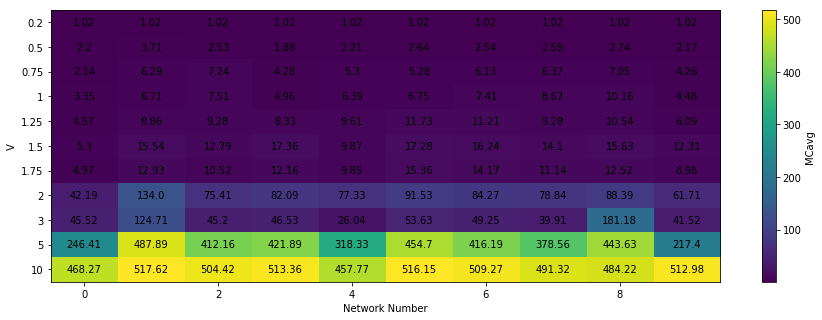

In [56]:
fig,axes=plt.subplots(1,1,figsize=(15,5))
# fig.subplots_adjust(wspace=0.3)
ax=axes
a=ax.imshow((avresultMC),aspect='auto')
plt.colorbar(a,ax=ax,label='MCavg')
for (j,i),label in np.ndenumerate((avresultMC)):
    ax.text(i,j,np.around(label,2),ha='center',va='center',color='k')
ax.set_yticks(np.arange(0,11))
ax.set_yticklabels(onAmp)
ax.set_ylabel('V')

ax.set_xlabel('Network Number')

### REWIRE NETWORKS:

In [15]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [56]:
graphRewired=[[] for i in range(len(graph))]
adjMat=[[] for i in range(len(graph))]
nws=np.linspace(0,8,6)
#Loop through rewiring from completely modular to completely integrated
for i in tqdm(range(len(graph))):
    for j in range(6):
        if i == 0:
            graphRewired[i].append((graph[i].copy()))
            currGraph=graphRewired[i][j]
        else:
            currGraph=graphRewired[i-1][j].copy()
        temp=[]
        temp=nx.double_edge_swap(currGraph,nswap=int(np.exp(nws[j])),max_tries=10000,seed=10)
        temp.remove_edges_from(list(nx.selfloop_edges(temp)))
        if i > 0:
            graphRewired[i].append(max(connected_component_subgraphs(temp), key=len))
        adjMat[i].append(nx.adjacency_matrix(graphRewired[i][j]))

  0%|          | 0/10 [00:00<?, ?it/s]

In [81]:
savemat(dataLoc+'Rewired_Hierarchical_2x3.mat',{'adj':adjMat})

In [59]:
avgSPL_rewired=[];SPLsource_drain_rewired=[]
for i in tqdm(range(len(graphRewired))):
    for j in range(len(graphRewired[i])):
        avgSPL_rewired.append(nx.average_shortest_path_length(graphRewired[i][j]))
        elecs=getFarthestPairing(nx.adjacency_matrix(graphRewired[i][j]).todense())
        SPLsource_drain_rewired.append(nx.shortest_path(graphRewired[i][j],elecs[0],elecs[1]))

  0%|          | 0/10 [00:00<?, ?it/s]

In [74]:
SPLlength_source_drain_rewired=[]
for i in range(len(SPLsource_drain_rewired)):
    SPLlength_source_drain_rewired.append(len(SPLsource_drain_rewired[i]))
SPLlength_source_drain_rewired=np.array(SPLlength_source_drain_rewired).reshape(10,6)
avgSPL_rewired=np.array(avgSPL_rewired).reshape(10,6)

In [75]:
avgSPL_rewired

array([[4.73337229, 4.47289371, 3.946266  , 3.37663884, 2.90579299,
        2.68393434],
       [4.52202003, 4.28169727, 3.73047858, 3.16370618, 2.77642738,
        2.67457429],
       [4.50986088, 4.16773511, 3.58815804, 3.04888147, 2.72370618,
        2.6732276 ],
       [4.47289371, 4.11220924, 3.44828047, 2.96865331, 2.70059544,
        2.67224263],
       [4.44760712, 4.00628826, 3.37737896, 2.91879243, 2.69301614,
        2.67499165],
       [4.3459655 , 3.95162493, 3.32920979, 2.87459655, 2.68513077,
        2.67663884],
       [4.33540902, 3.9320089 , 3.27786867, 2.84526989, 2.68348358,
        2.67882582],
       [4.29016138, 3.87765721, 3.23098497, 2.81804674, 2.68109071,
        2.67405676],
       [4.27019477, 3.85134669, 3.19530885, 2.79669449, 2.68136338,
        2.674335  ],
       [4.20966055, 3.81127435, 3.16602115, 2.7784808 , 2.68424597,
        2.67393434]])

In [72]:
SPLlength_source_drain_rewired

array([[12, 11,  9,  8,  7,  6],
       [11, 10,  9,  8,  7,  6],
       [11, 10,  8,  7,  6,  6],
       [11, 10,  8,  8,  6,  6],
       [11,  9,  8,  7,  6,  6],
       [10,  9,  8,  7,  6,  6],
       [10,  9,  8,  7,  6,  6],
       [10,  9,  8,  6,  6,  6],
       [10,  9,  8,  7,  6,  6],
       [10,  9,  8,  7,  6,  6]])

In [301]:
# #If we want to include the original graph (no minimal rewiring to start with)
# for i in range(len(graphRewired)): 
#     graphRewired[i].insert(0,graph[i])

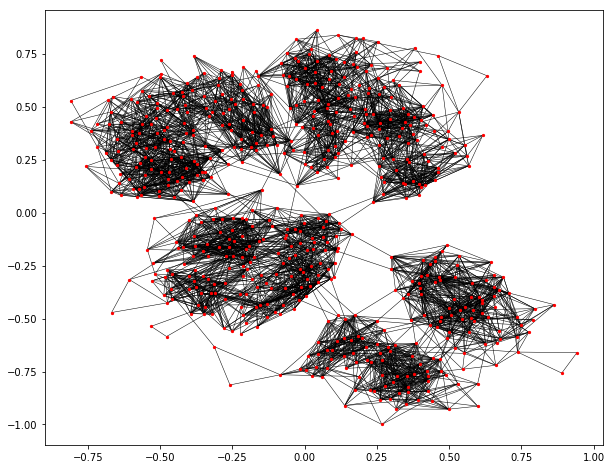

In [51]:
plt.figure(figsize=(10,8))
pos=nx.kamada_kawai_layout(graphRewired[0][0])
nx.draw_networkx(graphRewired[0][0],pos=pos,width=0.5,with_labels=False,node_size=5)

In [62]:
#save networks separately so Dask can run it more efficiently
count = 1
for i in tqdm(range(len(graphRewired))):#For each network
    for j in range(len(graphRewired[i])): #for each density
        n=connectivity__(graph=graphRewired[i][j])
        compressed_pickle(n,dataLoc+'/NWN_Network_Hierarchical_Rewired_'+str(i+1)+'_'+str(j+1)+'.pkl')
        count = count+1

  0%|          | 0/10 [00:00<?, ?it/s]

In [17]:
def nonlineartransRewired(j,k,amp=2):
    ampName=str(amp).replace('.','p')
    Connectivity=decompress_pickle(dataLoc+'NWN_Network_Hierarchical_Rewired_'+str(j+1)+'_'+str(k+1)+'.pkl')
    Graph= nx.from_numpy_matrix(Connectivity.adj_matrix)
    
    stimulus=[]
    dt = 1e-3
    f=0.5
    Time=10

    #Choose Electrode Pattern

    stimulus.append((stimulus__(biasType='AC',onAmp=amp,T=Time,dt=dt,f=f)))
    stimulus.append((stimulus__(biasType='Drain',T=Time,dt=dt))) #we don't want this drain to be active during training
    
    results_minMax=runSim(connectivity__(graph=Graph),stimulus=stimulus, contactMode='farthest',T = Time, dt = dt, onAmp = amp, biasType='AC',f=f,junctionMode='tunneling',findFirst=False)
    
#     results={'JunctionConductance':results_minMax.junctionConductance[-1],'JunctionVoltage':results_minMax.junctionVoltage[-1],'Switch':results_minMax.junctionSwitch[-1],'Source':results_minMax.sources[0:2],'Drain':results_minMax.drains[0:2],'Signal':results_minMax.stimulus,'conductance':results_minMax.conductance}
#     compressed_pickle(results,dataLoc+'_NLT_Simulation_'+'_2modules_Rewired_Network_'+str(j+1)+'_'+str(k+1)+'_'+ampName+'v.pkl')

    results_minMax.frequency=f
    results_minMax.dt=dt
    period=1/f
    
    nodesList = np.array([i for i in Graph.nodes]) #if we want to measure from all nodes
    
#     if elecs[0] in module1:   #if the NLT electrode is in module one, we only want to sample from those nodes
#         nodesList=module1 #only want nodes in first module
#     else:
#         nodesList=module2
        
    ResultSqu = nonLinearTrans_specificNodes(results_minMax,'Square',nodesList, repeats=50) #simulation, type of signal, number of nodes to sample from, number of linear regression repetitions (take avg)
    nwSqu=ResultSqu['accuracy']
        
    return nwSqu


In [26]:
def get_MC_VoltsweepRewired(j,k,amp = 2, dt = 0.01, dur = 1, n_outs = 100, init_state = None, return_sim = False):
    ampName=str(amp).replace('.','p')
    
    Connectivity=decompress_pickle(dataLoc+'NWN_Network_Hierarchical_Rewired_'+str(j+1)+'_'+str(k+1)+'.pkl')
    Graph= nx.from_numpy_matrix(Connectivity.adj_matrix)
    
    stimulus=[]
    stimulus.append(stimulus__(biasType='Custom',T=10,dt=dt,customSignal=signal_expand(np.random.random(1000)*2*amp-amp, dur)))
    stimulus.append(stimulus__(biasType='Drain',T=10,dt=dt)) #we don't want this drain to be active during training
    simRAND = runSim(connectivity__(graph=Graph), T = 10, dt = dt,
                stimulus=stimulus,
                biasType = 'Custom', customSignal = signal_expand(np.random.random(1000)*2*amp-amp, dur), 
                junctionMode = 'tunneling', 
#                 electrodes=elecs[-2:],
                contactMode = 'farthest',
                findFirst=False, disable_tqdm=True)    
    
    nodesList = np.array([i for i in Graph.nodes]) #if we want to measure from all nodes
    
#     results={'JunctionConductance':simRAND.junctionConductance[-1],'JunctionVoltage':simRAND.junctionVoltage[-1],'Switch':simRAND.junctionSwitch[-1],'Source':simRAND.sources[0:2],'Drain':simRAND.drains[0:2],'Signal':simRAND.stimulus,'conductance':simRAND.conductance}
#     compressed_pickle(results,dataLoc+'_MC_Simulation_'+'_2modules_Rewired_Network_'+str(j+1)+'_'+str(k+1)+'_'+ampName+'v.pkl')

    mcRAND = [MC_k_new(simRAND, m, node_list=nodesList) for m in range(dur, len(nodesList)*dur, dur)]
    
    if return_sim:
        return np.sum(mcRAND), simRAND, Graph, dur
    else:
        return np.sum(mcRAND)

In [57]:
initMC=[]
for i in tqdm(range(len(onAmp))): #for each voltage
    for j in range(len(graphRewired)): #for each network
        for k in range(6):#for each rewiring:        
            initMC.append(inputPacker(get_MC_VoltsweepRewired,j,k,amp=onAmp[i]))

  0%|          | 0/11 [00:00<?, ?it/s]

In [20]:
init=[]
for i in tqdm(range(len(onAmp))): #for each voltage
    for j in range(len(graphRewired)): #for each network
        for k in range(6):#for each modularity:
            init.append(inputPacker(nonlineartransRewired,j,k,amp=onAmp[i]))

  0%|          | 0/11 [00:00<?, ?it/s]

In [21]:
resultNLT=para_run(nonlineartransRewired,init,nCPU=10,start_method='fork')

  0%|          | 0/660 [00:00<?, ?it/s]

Running Simulation : 100%|██████████| 10000/10000 [02:20<00:00, 71.35it/s]


Running Simulation : 100%|██████████| 10000/10000 [02:13<00:00, 74.63it/s]


Running Simulation : 100%|██████████| 10000/10000 [02:36<00:00, 63.81it/s]


Running Simulation : 100%|██████████| 10000/10000 [02:13<00:00, 74.88it/s]


In [22]:
resultNLT=np.array(resultNLT).reshape(11,10,6)

In [23]:
avresultNLT=np.mean(resultNLT,axis=1)

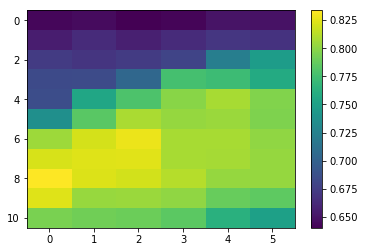

In [24]:
plt.imshow(avresultNLT,aspect='auto')
plt.colorbar()

In [58]:
resultMC=[]
for i in tqdm(range(10)):
    resultMC.append(para_run(get_MC_VoltsweepRewired,initMC,nCPU=10,start_method='fork'))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/660 [00:00<?, ?it/s]

Process ForkPoolWorker-46:
Process ForkPoolWorker-41:
Traceback (most recent call last):
  File "/suphys/aloe8475/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/suphys/aloe8475/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-47:
Traceback (most recent call last):
  File "/suphys/aloe8475/anaconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/suphys/aloe8475/anaconda3/lib/python3.7/multiprocessing/pool.py", line 47, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "/suphys/aloe8475/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/suphys/aloe8475/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-26-57bb008736f3>", line 

KeyboardInterrupt: 

In [226]:
avresultMC=np.mean(resultMC,axis=0)
stdresultMC=np.std(resultMC,axis=0)/np.sqrt(10)

In [229]:
avresultMC=np.array(avresultMC).reshape(11,10,6)
stdresultMC=np.array(stdresultMC).reshape(11,10,6)

In [230]:
avresultMC=np.mean(avresultMC,axis=1)

In [223]:
compressed_pickle([resultMC,resultNLT],dataLoc+'Hierarchical_NLT+MC.pkl')

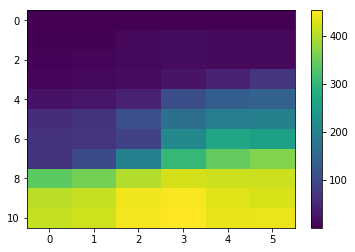

In [231]:
plt.imshow(avresultMC,aspect='auto')
plt.colorbar()

### MULTITASKING

In [90]:
#Set up modules
np.random.seed(10)
module1=[]
module2=[]
for nw in range(len(graph)):
    ci,q=bct.community_louvain(np.array(nx.adjacency_matrix(graph[nw]).todense()),gamma=0.01)
    module1.append(np.array([i for i in graph[nw].nodes])[ci==1])
    module2.append(np.array([i for i in graph[nw].nodes])[ci==2])
# module1=np.array(module1).reshape(10)
# module2=np.array(module2).reshape(10)


In [93]:
electrodes=[[128,45,195,251],[109,37,263,160],[128,26,265,187],[143,42,274,212],[97,71,267,178],[132,7,239,154],[76,20,291,155],[146,34,265,218],[100,14,270,163],[129,54,290,159]]

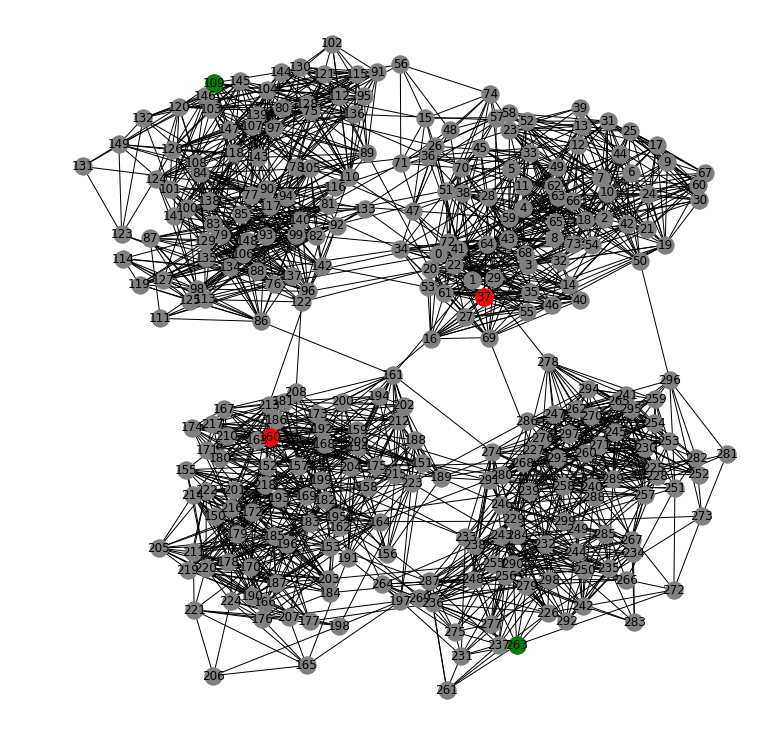

In [95]:
#Unseparated Networks
nw=1
# mod=0
plt.figure(figsize=(10,10))
pos=nx.kamada_kawai_layout(graph[nw])
nx.draw(graph[nw],pos=pos,with_labels=True,node_color='grey')
nx.draw_networkx_nodes(graph[nw],pos=pos,nodelist=[electrodes[nw][0],electrodes[nw][2]],node_color='green')
nx.draw_networkx_nodes(graph[nw],pos=pos,nodelist=[electrodes[nw][1],electrodes[nw][3]],node_color='red')

In [362]:
def get_MC_and_NLT(j,elecs,module1,module2,seed=42,noiseOn=False,amp = 2, dt = 0.01, dur = 1, n_outs = 100, init_state = None, return_sim = False):
    ampName=str(amp).replace('.','p')
    f=0.5

    Connectivity=decompress_pickle(dataLoc+'/NWN_Hierarchical Network_2x2'+'_'+str(j+1)+'.pkl')
    Graph= nx.from_numpy_matrix(Connectivity.adj_matrix)
    
    np.random.seed(seed)
    stimulus=[]
    #KEEP NLT CONSTANT WHILE CHANGING MC
    stimulus.append(stimulus__(biasType='AC',onAmp=amp,TimeVector=np.arange(0,10,dt),f=f))
    stimulus.append(stimulus__(biasType='Drain',TimeVector=np.arange(0,10,dt))) #we don't want this drain to be active during training
#     stimulus.append(stimulus__(biasType='AC',onAmp=amp,TimeVector=np.arange(0,10,dt),f=f))
    stimulus.append(stimulus__(biasType='Custom',TimeVector=np.arange(0,10,dt),customSignal=signal_expand(np.random.random(int(1000/dur))*2*amp-amp, dur)))
    stimulus.append(stimulus__(biasType='Drain',TimeVector=np.arange(0,10,dt))) #we don't want this drain to be active during training
#     #White noise
#     if noiseOn:
#         noise=[gauss(0.0, 1.0) for i in range(1000)]
#         stimulus.append(stimulus__(biasType='Custom',TimeVector=np.arange(0,10,dt),customSignal=signal_expand(noise, dur)))
    
    simRAND = runSim(connectivity__(graph=Graph), T = 10, dt = dt,
                start_state =  init_state,
                stimulus=stimulus,
                onAmp=amp,
                junctionMode = 'tunneling', 
                contactMode = 'preSet',
                electrodes=elecs,
                findFirst=False, disable_tqdm=True)

#     output={'JunctionConductance':simRAND.junctionConductance,'JunctionVoltage':simRAND.junctionVoltage,'Switch':simRAND.junctionSwitch,'Source':simRAND.sources[0:2],'Drain':simRAND.drains[0:2],'Signal':simRAND.stimulus}
#     if noiseOn:
#         compressed_pickle(output,dataLoc+'NLT+MC+NOISE_Electrodes_'+'REWIREDNetworkComparison_'+str(j+1)+'_'+str(k+1)+'_'+ampName+'v.pkl')
#     else:
#         compressed_pickle(output,dataLoc+'NLT2+NLT_Electrodes_seed10_'+'REWIRED_'+str(j+1)+'_'+str(k+1)+'_'+ampName+'v.pkl')

   
    nodesList=[]
    if elecs[3] in module1:   #if the electrode is in module one, we only want to sample from those nodes
        nodesList=module1 #only want nodes in first module
    else: #otherwise, we want to sample from module two
        nodesList=module2 #only want nodes in second module
        
    # 2x NLT
    nlt2F = nonLinearTrans_specificNodes(simRAND,'Square',nodesList, repeats=50) #simulation, type of signal, number of nodes to sample from, number of linear regression repetitions (take avg)
    nwSqu2=nlt2F['accuracy']
    
    # NORMAL MC
    #     mcRAND = [MC_k_new(simRAND, l, node_list=nodesList) for l in range(dur, len(nodesList)*dur, dur)]
    
    nodesList=[]
    if elecs[0] in module1:  
        nodesList=module1 
    else:
        nodesList=module2    
        
    countK=0

    ResultSqu = nonLinearTrans_specificNodes(simRAND,'Square',nodesList, repeats=50) #simulation, type of signal, number of nodes to sample from, number of linear regression repetitions (take avg)
    nwSqu=ResultSqu['accuracy']
    
    if return_sim:
        return np.sum(mcRAND), simRAND, nwSqu
    else:
        return nwSqu2,nwSqu#np.sum(mcRAND),nwSqu

In [363]:
noiseOn=False #Add white noise?

if noiseOn:
    elecs=electrodesNoise
else:
    elecs=electrodes
initMCNLT=[[] for i in range(10)]
seed=np.arange(10,21) #10 different seeds
for nTimes in tqdm(range(10)):
    for i in range(len(onAmp)): #for each voltage
        for j in range(len(graph)): #for each network
            initMCNLT[nTimes].append(inputPacker(get_MC_and_NLT,j,electrodes[j],module1[j],module2[j],noiseOn=noiseOn,amp=onAmp[i],seed=seed[nTimes]))

In [364]:
get_MC_and_NLT(1,electrodes[1],module1[1],module2[1],noiseOn=False,amp=onAmp[5],seed=seed[0])

Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x7f4ffbb4fb10>
Traceback (most recent call last):
  File "/suphys/aloe8475/anaconda3/lib/python3.7/site-packages/tqdm/_tqdm_notebook.py", line 226, in __iter__
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'


ValueError: shape mismatch: value array of shape (5428,) could not be broadcast to indexing result of shape (5478,)

In [334]:
#Run
resultMCNLT=[None]*10
for i in tqdm(range(10)):
    resultMCNLT[i]=para_run(get_MC_and_NLT,initMCNLT[i],nCPU=10,start_method='fork')

Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x7f5019902138><generator object tqdm_notebook.__iter__ at 0x7f5019902138><generator object tqdm_notebook.__iter__ at 0x7f5019902138><generator object tqdm_notebook.__iter__ at 0x7f5019902138><generator object tqdm_notebook.__iter__ at 0x7f5019902138><generator object tqdm_notebook.__iter__ at 0x7f5019902138>



<generator object tqdm_notebook.__iter__ at 0x7f5019902138>
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):

Exception ignored in: 
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/suphys/aloe8475/anaconda3/lib/python3.7/site-packages/tqdm/_tqdm_notebook.py", line 226, in __iter__
  File "/suphys/aloe8475/anaconda3/lib/python3.7/

ValueError: shape mismatch: value array of shape (5356,) could not be broadcast to indexing result of shape (5402,)

In [233]:
MC=[]
# NLT2=[]
NLT=[]
for i in range(len(resultMCNLT)):
    MC.append(np.array(resultMCNLT[i]).T[0].reshape(11,10))
    NLT.append(np.array(resultMCNLT[i]).T[1].reshape(11,10))

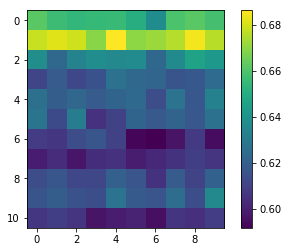

In [234]:
plt.imshow(np.mean(NLT,axis=0))
plt.colorbar()